In [101]:
%config InlineBackend.figure_format = "retina"

In [1]:
! pip install scikit-learn

In [4]:
import duckdb

In [16]:
transactions = duckdb.read_csv('../data/transactions.csv')

Objectif:
> Créer un petit algo simple qui prédit en fonction de la date de jour, date de premier achat, valeur du premier achat, type de premier achat, genre, country la probabilité d'acheter la semaine d'après > permet de sortir le top score par pays

In [21]:
duckdb.query("SELECT * FROM transactions")

┌────────────────────┬──────────────────┬─────────────────────┬─────────┬──────────────────┬────────────────────┐
│     client_id      │ transaction_date │ country_of_purchase │ gender  │    price_full    │ product_collection │
│      varchar       │       date       │       varchar       │ varchar │      double      │      varchar       │
├────────────────────┼──────────────────┼─────────────────────┼─────────┼──────────────────┼────────────────────┤
│ 0011i00000SzBVHAA3 │ 2017-04-10       │ Thailand            │ Male    │ 10121.0147819178 │ Collection 6       │
│ 0011i00000SydhuAAB │ 2015-09-18       │ Malaysia            │ Male    │ 3591.17458743828 │ Collection 6       │
│ 0011i00000Sydm4AAB │ 2015-03-31       │ Malaysia            │ Female  │ 7310.30751894496 │ Collection 6       │
│ 0011i00000SydiFAAR │ 2015-10-09       │ Malaysia            │ Male    │ 9487.76878457763 │ Collection 8       │
│ 0011i00000SycixAAB │ 2015-03-26       │ Malaysia            │ Male    │ 27987.31690135

In [87]:
transactions_cumulative = duckdb.query(
"""
SELECT
    -- ROW_NUMBER() OVER () AS transaction_id,
    client_id,
    country_of_purchase,
    IF(gender = 'Male', 1, 0) AS is_male,
    CAST(price_full AS INT) AS transaction_price,
    CAST(SUM(price_full) OVER (PARTITION BY client_id ORDER BY transaction_date ASC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS INT) AS total_spent_lifetime,
    COUNT(1) OVER (PARTITION BY client_id ORDER BY transaction_date ASC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_transactions_lifetime,
    DATE_DIFF('day', LAG(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date), transaction_date) AS days_since_last_purchase,
    LEAD(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date) IS NOT NULL AS has_returned,
    LAG(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date) IS NULL AS is_first_venue,
    LAG(product_collection) OVER (PARTITION BY client_id ORDER BY transaction_date) AS last_product_purchased
FROM transactions          
-- QUALIFY COUNT(1) OVER (PARTITION BY client_id) > 1
ORDER BY client_id, transaction_date
""")

# TODO: group by day to predict return

In [88]:
transactions_cumulative.df().query("client_id == '0011i00001jagxpAAA'")

,client_id,country_of_purchase,is_male,transaction_price,total_spent_lifetime,total_transactions_lifetime,days_since_last_purchase,has_returned,is_first_venue,last_product_purchased
59990,0011i00001jagxpAAA,"Utd,Arab Emir,",1,21435,21435,1,NaN,True,True,None
59991,0011i00001jagxpAAA,"Utd,Arab Emir,",1,13179,34614,2,0.0,True,False,Collection 1
59992,0011i00001jagxpAAA,"Utd,Arab Emir,",1,18607,53221,3,0.0,True,False,Collection 1
59993,0011i00001jagxpAAA,"Utd,Arab Emir,",1,18960,72181,4,31.0,True,False,Collection 1
59994,0011i00001jagxpAAA,"Utd,Arab Emir,",1,20530,92711,5,1.0,False,False,Collection 1


In [89]:
transactions_cumulative.df().sample(n=10)

,client_id,country_of_purchase,is_male,transaction_price,total_spent_lifetime,total_transactions_lifetime,days_since_last_purchase,has_returned,is_first_venue,last_product_purchased
8717,0011i00000SzHpuAAF,"Macau SAR, China",1,12095,12095,1,NaN,False,True,None
51776,0011i00000nKV1sAAG,"Macau SAR, China",1,9441,9441,1,NaN,False,True,None
20193,0011i00000YPyDuAAL,Switzerland,0,8882,8882,1,NaN,True,True,None
33436,0011i00000YUZr1AAH,South Korea,1,4630,4630,1,NaN,False,True,None
17274,0011i00000YPBMzAAP,France,1,6512,6512,1,NaN,False,True,None
37786,0011i00000j8RZtAAM,China,1,5957,5957,1,NaN,False,True,None
19342,0011i00000YPouRAAT,"Hong Kong SAR, China",1,8944,8944,1,NaN,True,True,None
33005,0011i00000YUWUgAAP,South Korea,1,11238,11238,1,NaN,False,True,None
4774,0011i00000SynigAAB,USA,1,6765,6765,1,NaN,False,True,None
47502,0011i00000nK46iAAH,"Hong Kong SAR, China",1,12197,70185,4,301.0,True,False,Collection 1


[Text(0, 0, '0.880917'), Text(0, 0, '0.119083')]

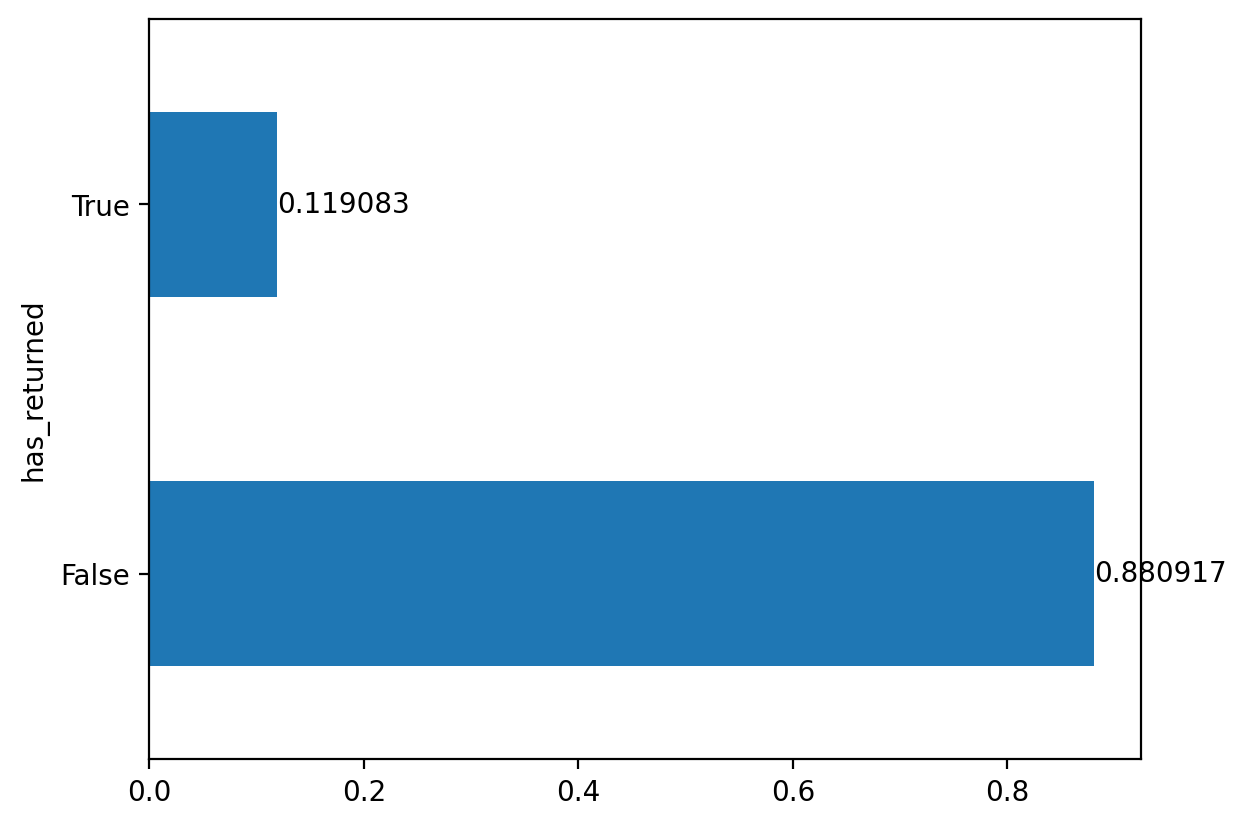

In [104]:
ax = transactions_cumulative.df()["has_returned"].value_counts(normalize=True).plot.barh()
ax.bar_label(ax.containers[0])

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix

df = transactions_cumulative.df()

test_size = 0.2
random_state = 54

X, y = df.drop(columns=["client_id", "has_returned"]), df.get("has_returned")

categorical_features = ["country_of_purchase", "last_product_purchased"]

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        # ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough"
)

preprocessor.set_output(transform="pandas")


clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", HistGradientBoostingClassifier(random_state=random_state)),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

clf.fit(X_train, y_train)
print(f"model score: {clf.score(X_test, y_test):.3f}")

y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))

model score: 0.892
[[10421   142]
 [ 1152   285]]


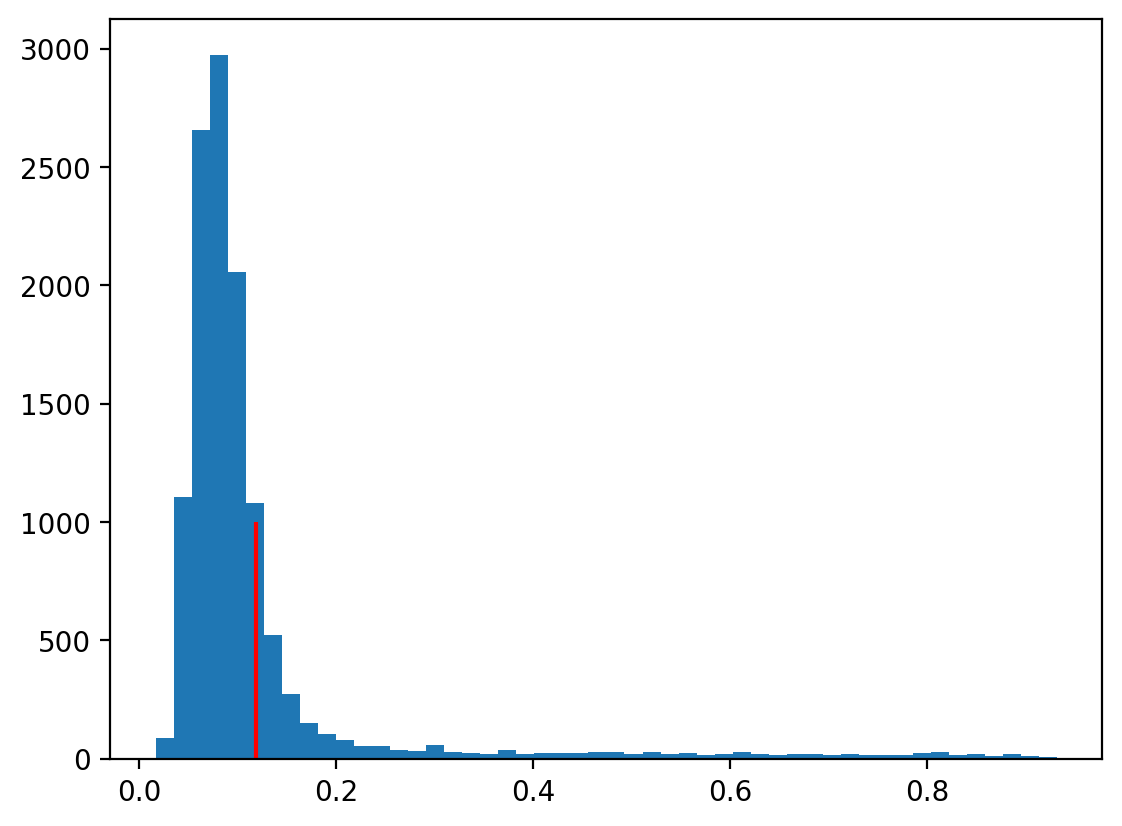

In [180]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(clf.predict_proba(X_test)[:,1], bins=50)
plt.vlines(x=np.mean(clf.predict_proba(X_test)[:,1]), ymin=0, ymax=1000, color='r')
plt.show()

The purchase frequency follows a Poisson process while they are considered ‘active’.

## Time before return

In [176]:
transactions_time_before_return = duckdb.query(
"""
SELECT
    -- ROW_NUMBER() OVER () AS transaction_id,
    client_id,
    country_of_purchase,
    IF(gender = 'Male', 1, 0) AS is_male,
    CAST(price_full AS INT) AS transaction_price,
    CAST(SUM(price_full) OVER (PARTITION BY client_id ORDER BY transaction_date ASC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS INT) AS total_spent_lifetime,
    COUNT(1) OVER (PARTITION BY client_id ORDER BY transaction_date ASC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_transactions_lifetime,
    DATE_DIFF('day', LAG(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date), transaction_date) AS days_since_last_purchase,
    LAG(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date) IS NULL AS is_first_venue,
    LAG(product_collection) OVER (PARTITION BY client_id ORDER BY transaction_date) AS last_product_purchased,
    DATE_DIFF('day', transaction_date, LEAD(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date)) AS time_before_next_purchase,
FROM transactions          
-- QUALIFY COUNT(1) OVER (PARTITION BY client_id) > 1
QUALIFY time_before_next_purchase IS NOT NULL
ORDER BY client_id, transaction_date
""")

transactions_time_before_return.df().sample(n=10)
# TODO: group by day to predict return

,client_id,country_of_purchase,is_male,transaction_price,total_spent_lifetime,total_transactions_lifetime,days_since_last_purchase,is_first_venue,last_product_purchased,time_before_next_purchase
1574,0011i00000YPD6IAAX,USA,1,11829,11829,1,NaN,True,None,0
1900,0011i00000YQaYtAAL,USA,1,10506,10506,1,NaN,True,None,0
2286,0011i00000YSXpyAAH,Singapore,1,11886,11886,1,NaN,True,None,0
1397,0011i00000Y2T8IAAV,USA,1,6676,6676,1,NaN,True,None,0
6725,0011i00000nLTlVAAW,South Korea,1,5447,17077,2,107.0,False,Collection 1,187
6285,0011i00000nLFBHAA4,USA,1,8896,8896,1,NaN,True,None,169
3725,0011i00000nJOp2AAG,USA,1,9722,80777,6,84.0,False,Collection 9,6
5931,0011i00000nKdPzAAK,USA,1,5273,5273,1,NaN,True,None,34
3431,0011i00000j8glhAAA,China,1,5870,5870,1,NaN,True,None,0
6017,0011i00000nKomZAAS,China,1,10661,28288,2,362.0,False,Collection 1,0


In [178]:
transactions_time_before_return.df().query("client_id == '0011i00000nLTlVAAW'")

,client_id,country_of_purchase,is_male,transaction_price,total_spent_lifetime,total_transactions_lifetime,days_since_last_purchase,is_first_venue,last_product_purchased,time_before_next_purchase
6724,0011i00000nLTlVAAW,South Korea,1,11630,11630,1,NaN,True,None,107
6725,0011i00000nLTlVAAW,South Korea,1,5447,17077,2,107.0,False,Collection 1,187


<Axes: ylabel='Frequency'>

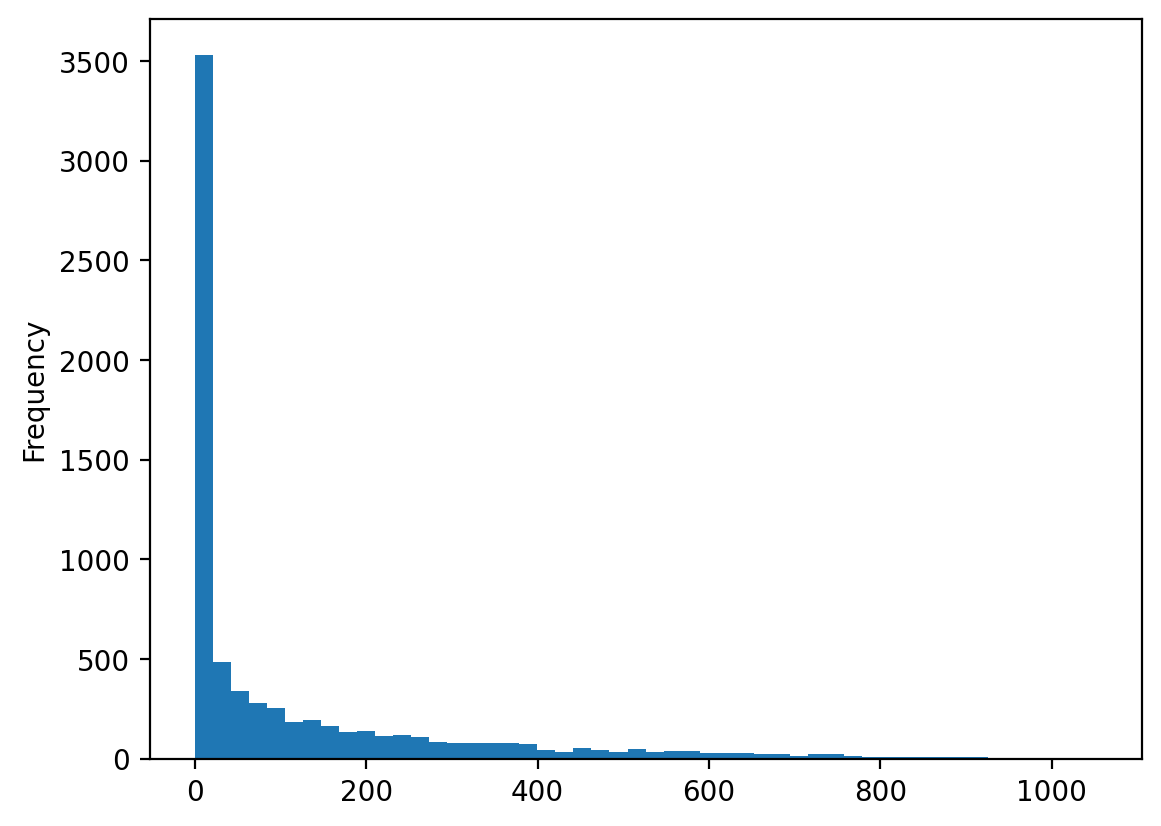

In [183]:
transactions_time_before_return.df()["time_before_next_purchase"].plot.hist(bins=50)

In [185]:
duckdb.query("SELECT MIN(transaction_date), MAX(transaction_date) FROM transactions")

┌───────────────────────┬───────────────────────┐
│ min(transaction_date) │ max(transaction_date) │
│         date          │         date          │
├───────────────────────┼───────────────────────┤
│ 2015-01-01            │ 2017-12-31            │
└───────────────────────┴───────────────────────┘

In [262]:
repurchase_time = duckdb.query(
f"""
    SELECT
        client_id,
        transaction_date,
        country_of_purchase,
        product_collection AS product_purchased,
        CAST(SUM(price_full) OVER (PARTITION BY client_id ORDER BY transaction_date ASC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS INT) AS total_spent_lifetime,
        COUNT(1) OVER (PARTITION BY client_id ORDER BY transaction_date ASC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_transactions_lifetime,
        LAG(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date) IS NULL AS is_first_venue,
        DATE_DIFF('day', transaction_date, LEAD(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date)) AS days_since_next_purchase,
    FROM transactions
    QUALIFY days_since_next_purchase > 0
""")

repurchase_time_df = repurchase_time.df()

repurchase_time_df


,client_id,transaction_date,country_of_purchase,product_purchased,total_spent_lifetime,total_transactions_lifetime,is_first_venue,days_since_next_purchase
0,0011i00000S5cKFAAZ,2015-03-18,"Russian Fed,",Collection 5,8944,1,True,469
1,0011i00000S5cKFAAZ,2016-06-29,"Russian Fed,",Collection 8,79582,2,False,138
2,0011i00000S5d0SAAR,2016-02-01,Brazil,Collection 6,5729,1,True,517
3,0011i00000S5dSnAAJ,2017-12-18,South Korea,Collection 8,18776,1,True,3
4,0011i00000S5f4uAAB,2017-04-09,South Korea,Collection 5,14073,1,True,26
...,...,...,...,...,...,...,...,...
4488,0011i00000YUAdvAAH,2015-09-28,"Utd,Arab Emir,",Collection 3,19042,3,False,175
4489,0011i00000YUAdvAAH,2016-03-21,"Utd,Arab Emir,",Collection 4,22113,4,False,569
4490,0011i00000YUHiyAAH,2015-08-09,"Utd,Arab Emir,",Collection 4,14447,1,True,25
4491,0011i00000YUQdJAAX,2015-04-25,"Taiwan, China",Collection 2,13510,1,True,321


<Axes: ylabel='Frequency'>

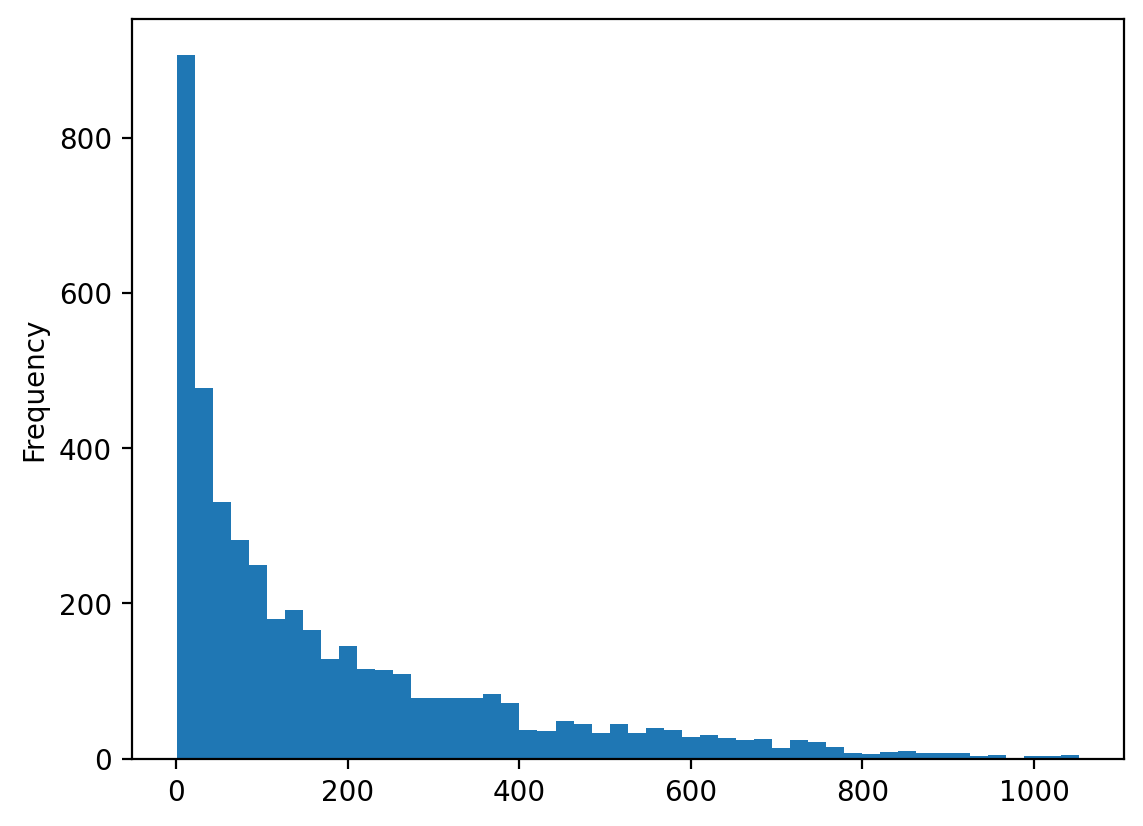

In [258]:
repurchase_time_df["days_since_next_purchase"].plot.hist(bins=50)

model score: -0.017


Text(0, 0.5, 'predicted')

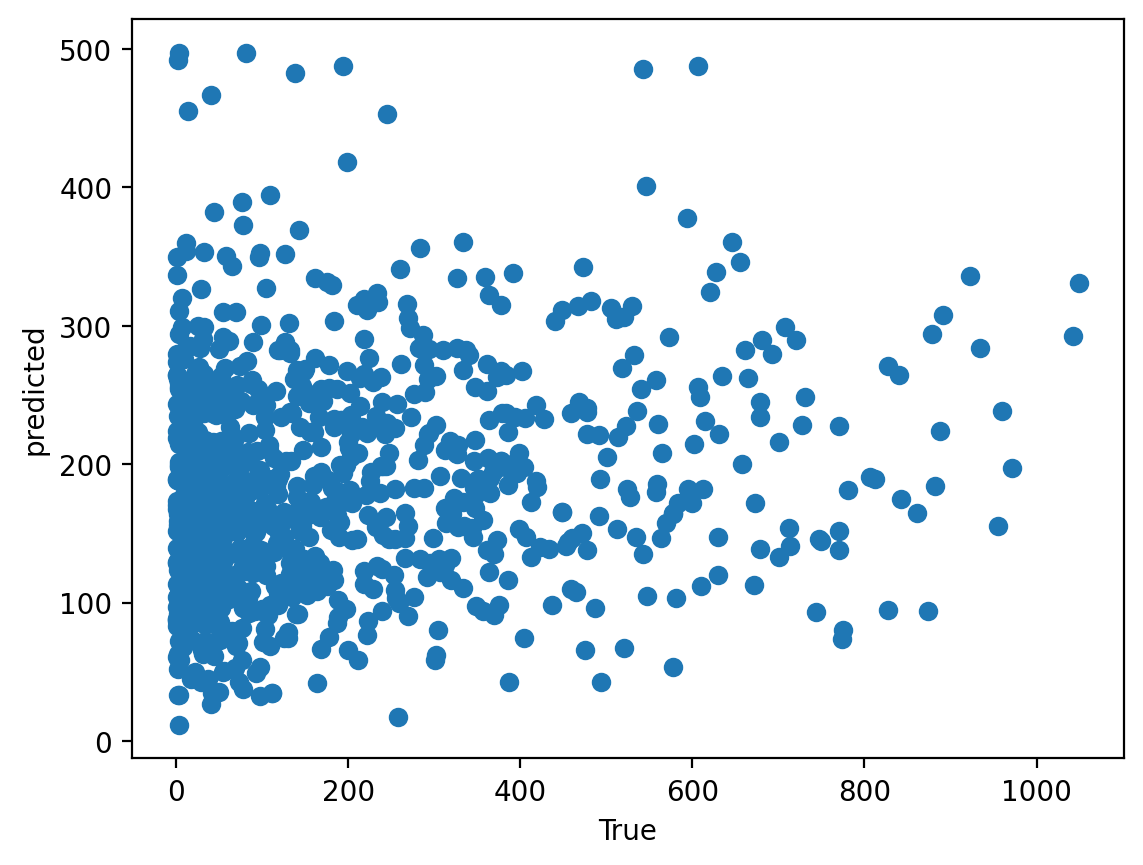

In [287]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, PredictionErrorDisplay


test_size = 0.2
random_state = 54

target_col = "days_since_next_purchase"

df = repurchase_time_df.query("days_since_next_purchase == days_since_next_purchase")

X, y = repurchase_time_df.drop(columns=["transaction_date", "client_id", target_col]), df.get(target_col)

categorical_features = ["country_of_purchase", "product_purchased"]

X[categorical_features] = X[categorical_features].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

est = HistGradientBoostingRegressor(random_state=random_state, categorical_features="from_dtype")

est.fit(X_train, y_train)
print(f"model score: {est.score(X_test, y_test):.3f}")

y_pred = est.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("True")
plt.ylabel("predicted")


# v2 - daily aggregation

[Text(0, 0, '0.947649'), Text(0, 0, '0.0523508')]

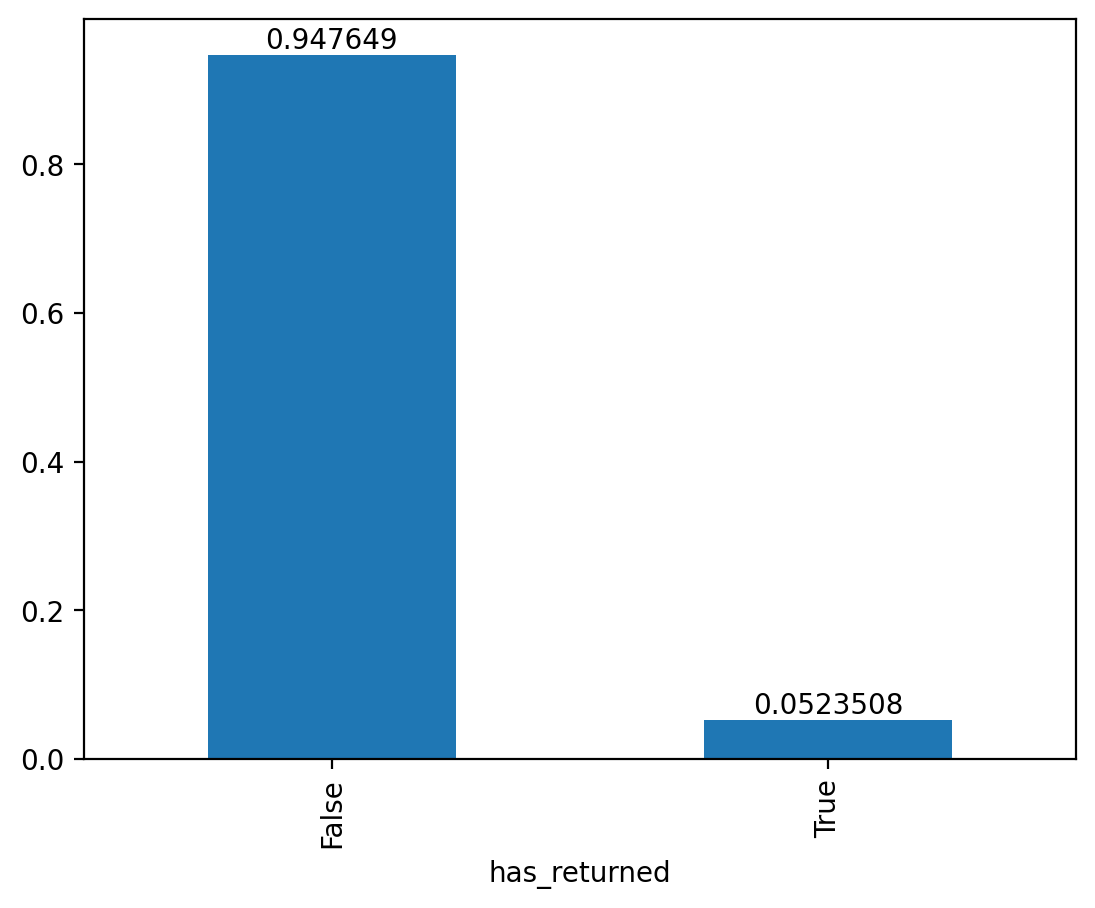

In [291]:
ax = duckdb.query(
"""
WITH daily_transactions AS (
SELECT
    client_id,
    transaction_date,
    CAST(SUM(price_full) AS INT) AS daily_total_price,
FROM transactions
GROUP BY client_id,transaction_date,
)
SELECT
    client_id,
    COUNT(transaction_date) AS n_transactions,
    COUNT(transaction_date) > 1 AS has_returned
FROM daily_transactions
GROUP BY client_id
""").df()["has_returned"].value_counts(normalize=True).plot.bar()
ax.bar_label(ax.containers[0])

<Axes: ylabel='Frequency'>

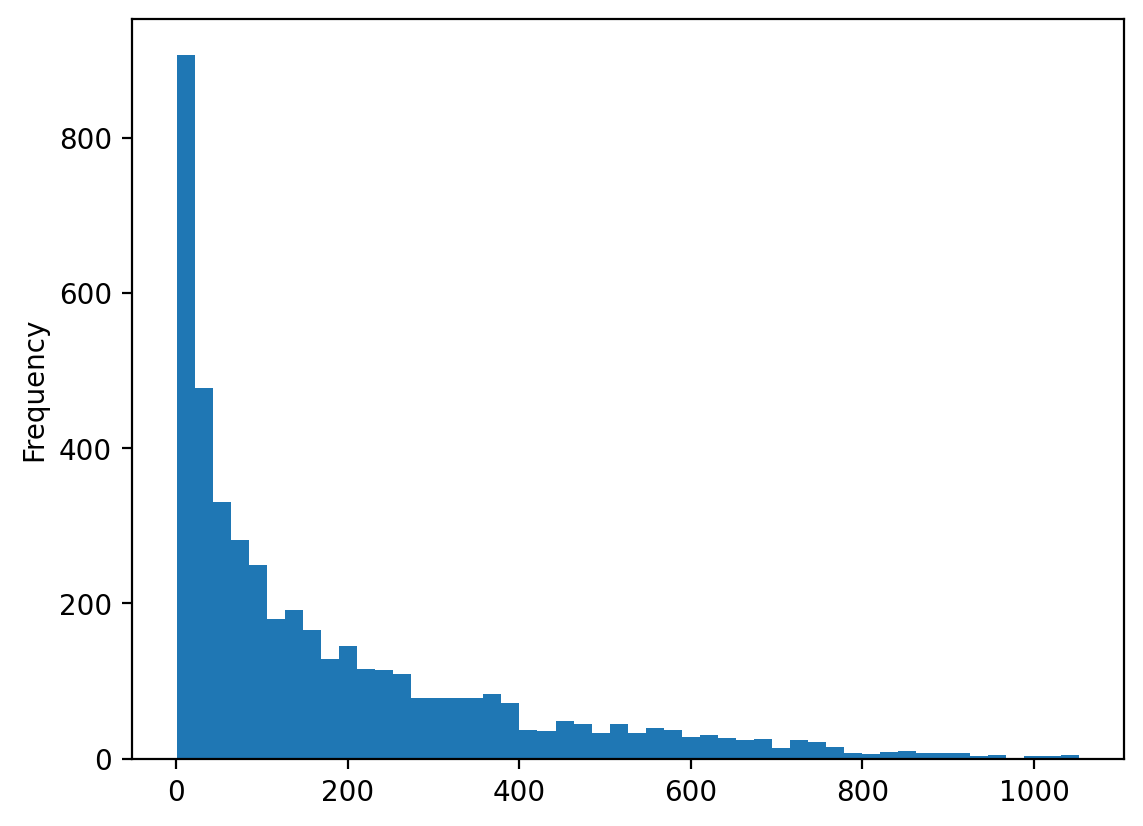

In [299]:
duckdb.query(
"""
WITH daily_transactions AS (
SELECT
    client_id,
    transaction_date,
    DATE_DIFF('day', transaction_date, LEAD(transaction_date) OVER(PARTITION BY client_id ORDER BY transaction_date ASC)) AS time_before_next_transactions,
    CAST(SUM(price_full) AS INT) AS daily_total_price,
FROM transactions
GROUP BY client_id,transaction_date,
)
SELECT
    *
FROM daily_transactions
WHERE time_before_next_transactions IS NOT NULL
""").df()["time_before_next_transactions"].plot.hist(bins=50)

In [331]:
transition_df = duckdb.query(
"""
-- we keep only transactions made with only one item
WITH transactions_with_one_product AS (
SELECT
    client_id,
    transaction_date,
FROM transactions
GROUP BY client_id, transaction_date
HAVING COUNT(1) = 1
),
next_purchase AS (
SELECT
    t.client_id,
    t.transaction_date,
    t.product_collection AS product_purchased,
    LEAD(t.product_collection) OVER(PARTITION BY t.client_id ORDER BY t.transaction_date ASC) AS next_product_purchased,
    LEAD(t.transaction_date) OVER(PARTITION BY t.client_id ORDER BY t.transaction_date ASC) AS next_transaction_date,
FROM transactions t
INNER JOIN transactions_with_one_product dt ON dt.client_id=t.client_id AND dt.transaction_date=t.transaction_date
-- we only keep transaction followed by another transactions
QUALIFY next_product_purchased IS NOT NULL
),
next_purchase_count AS (
SELECT
    product_purchased AS first_product,
    next_product_purchased AS next_product,
    COUNT(1) AS n_user,
FROM next_purchase
GROUP BY 1,2
)
PIVOT next_purchase_count
ON next_product
USING sum(n_user)
ORDER BY first_product
""").df()

Idée : créer un graphe par pays/genre pour visualiser dans Looker Studio

In [343]:
transition_df.set_index("first_product").fillna(0).astype(int).style.background_gradient(axis=1)

,Collection 1,Collection 2,Collection 3,Collection 4,Collection 5,Collection 6,Collection 7,Collection 8,Collection 9
first_product,,,,,,,,,
Collection 1,798,0,0,0,0,0,366,0,204
Collection 2,0,156,88,107,0,0,0,0,0
Collection 3,0,106,147,115,0,0,0,0,0
Collection 4,0,82,97,232,0,0,0,0,0
Collection 5,0,0,0,0,105,69,0,54,0
Collection 6,0,0,0,0,61,91,0,26,0
Collection 7,276,0,0,0,0,0,233,0,137
Collection 8,0,0,0,0,50,32,0,28,0
Collection 9,127,0,0,0,0,0,104,0,59
